## In this notebook, we use Care for pair wise training. Here the input are images which have been denoised using N2V. The output are images which are the original raw images.


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator



Using TensorFlow backend.


## Load Input and Output Data 

In [2]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img) for img in filenames]

print(len(imgs))
print(imgs[0].shape)

10
(70, 896, 576)


## Take only the latter half of the z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][35:70, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(35, 896, 576)


In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][0:35, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(35, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img) for img in filenames]

print(len(imgs))
print(imgs[0].shape)

10
(70, 896, 576)


## Take only the first half of the z-slices from CM03

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][0:35, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(35, 896, 576)


In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][35:70, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(35, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(35, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(35, 896, 576)


## Visualize the images 

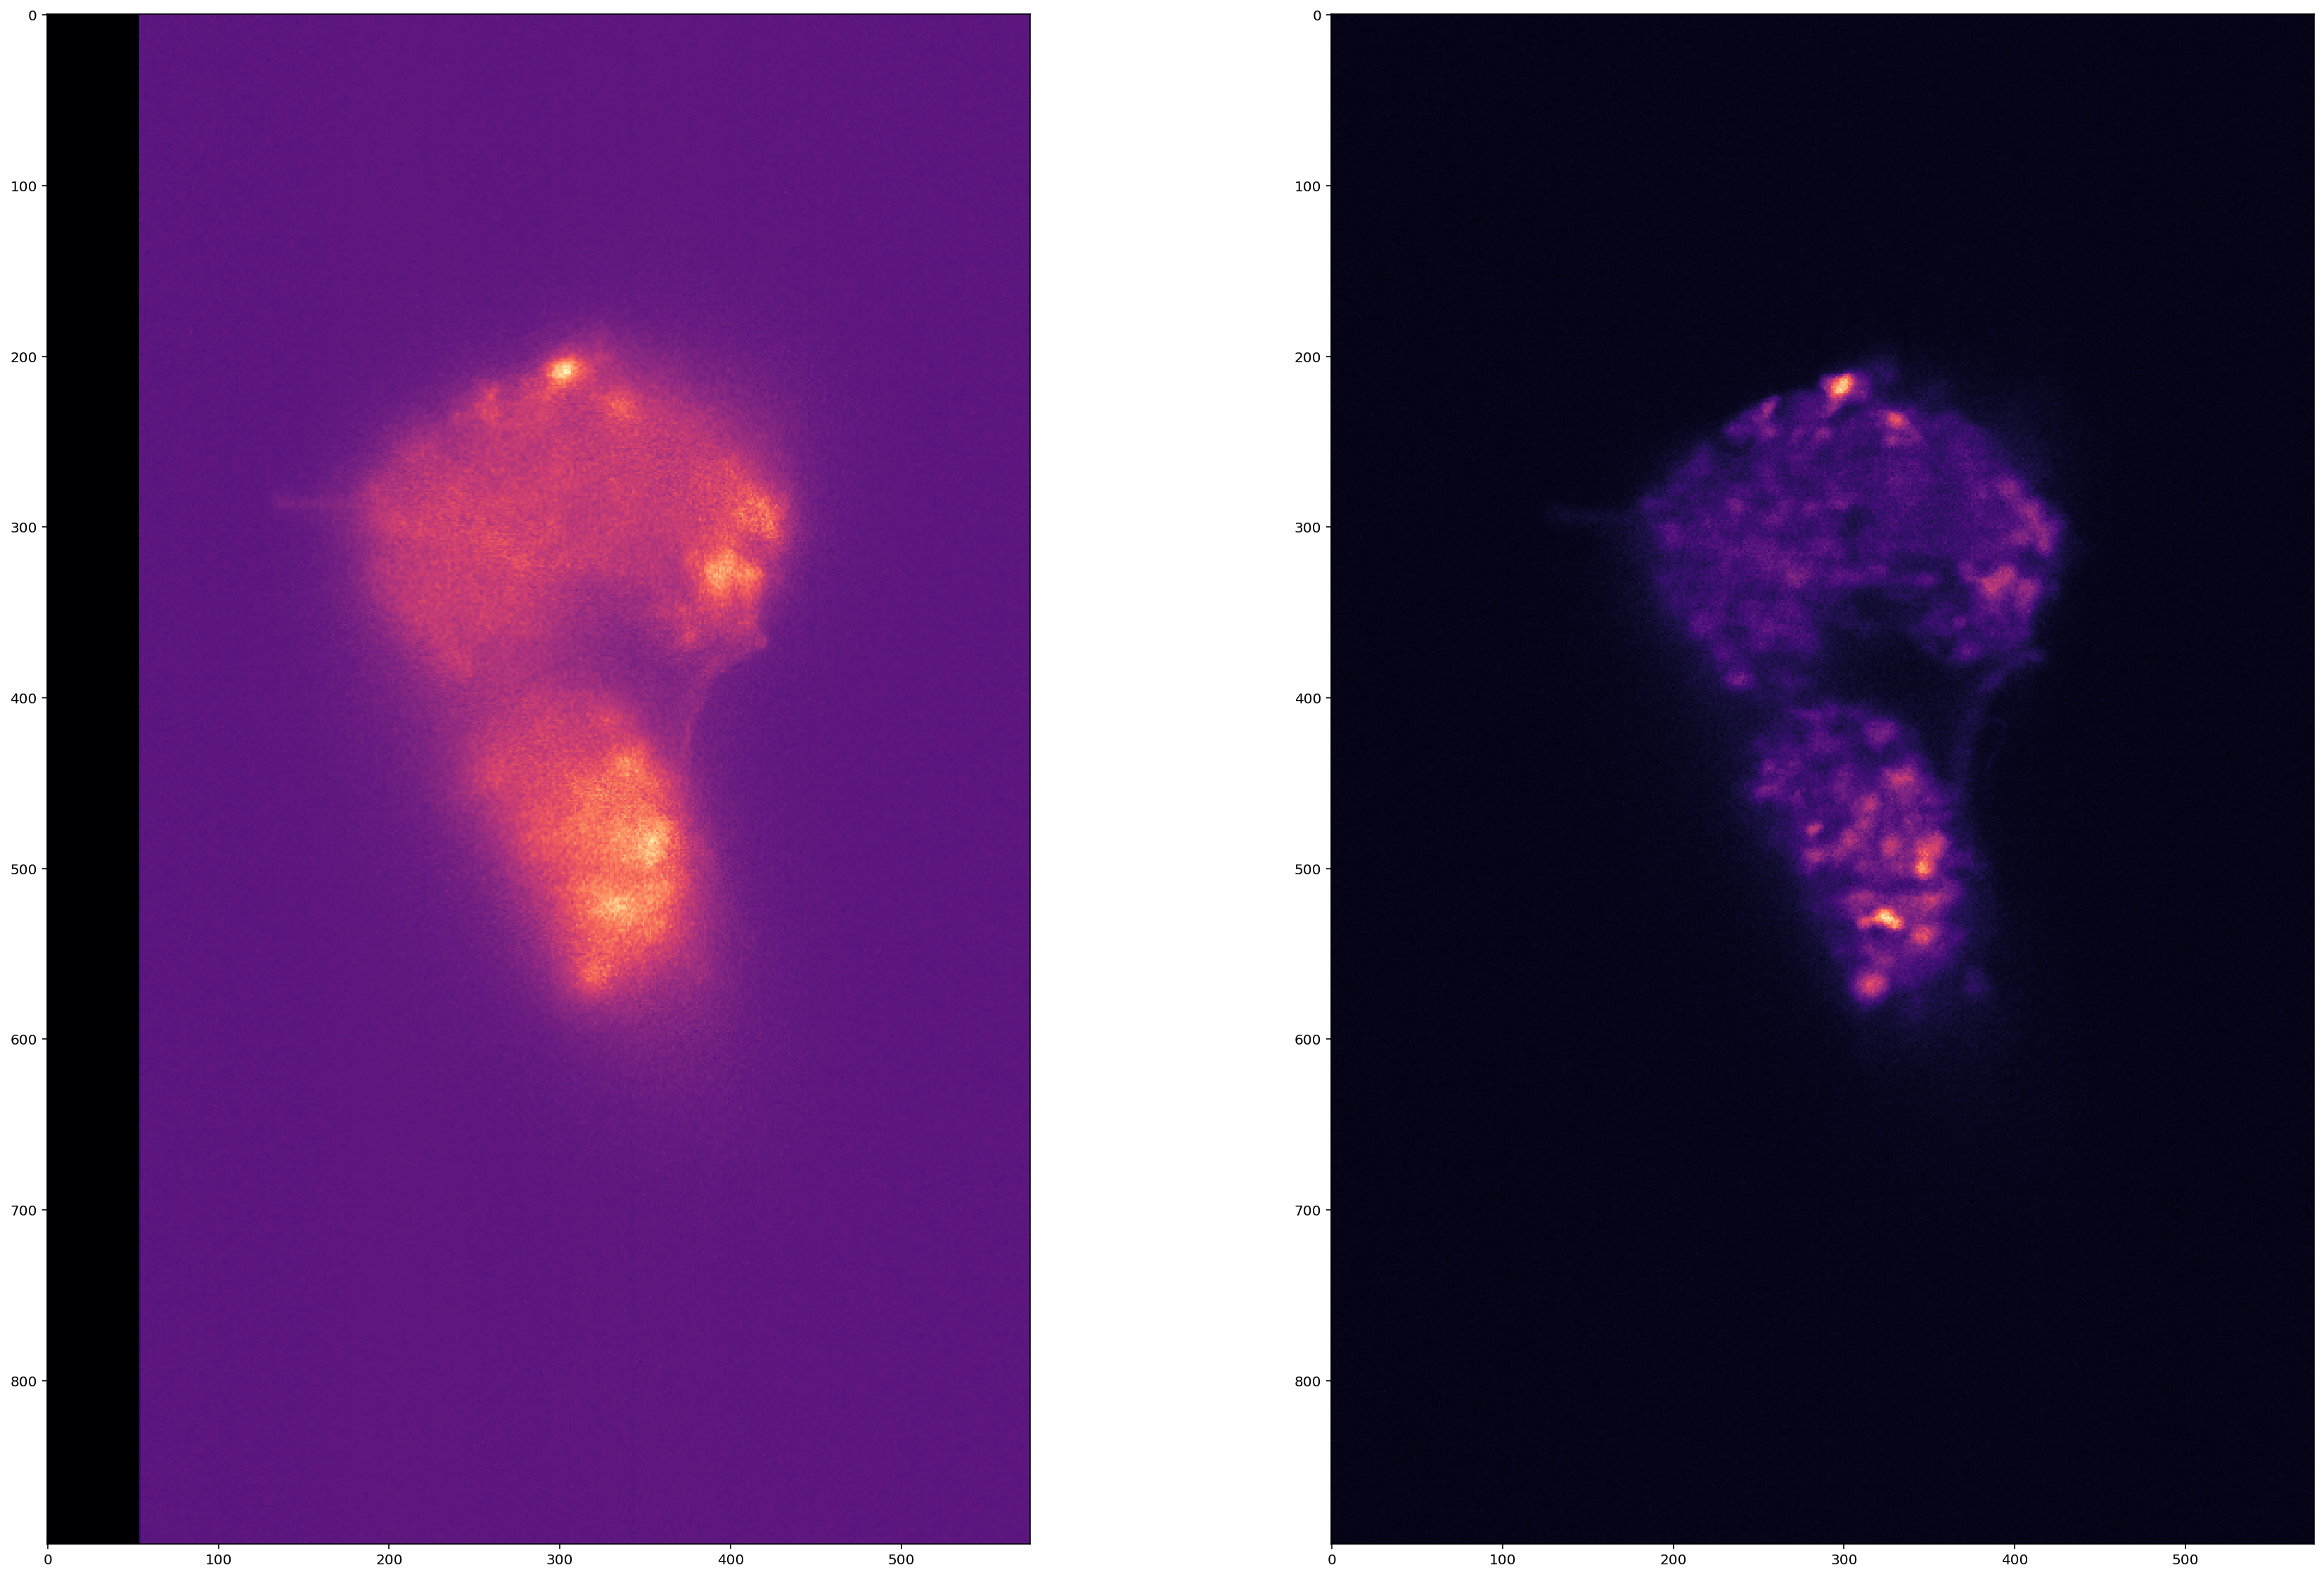

In [10]:
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[6][20,...], cmap='magma')
plt.subplot(1,2,2)
plt.imshow(imgsY[6][20,...], cmap='magma')
plt.show()

## Create patches

In [11]:
imgsX=np.vstack(imgsX)
print(imgsX.shape)
imgsY=np.vstack(imgsY)
print(imgsY.shape)

(700, 896, 576)
(700, 896, 576)


In [12]:
combined=np.empty([700, 896, 576, 2])
combined[..., 0]=imgsX
combined[..., 1]=imgsY
print(combined.shape)
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

(700, 896, 576, 2)
1


In [13]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=False)
print(patches.shape)

Generated patches: (31500, 96, 96, 2)
(31500, 96, 96, 2)


## Create train and validation pairs

In [14]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (30500, 96, 96, 1)
Y shape:  (30500, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


## Plot some examples from validation data

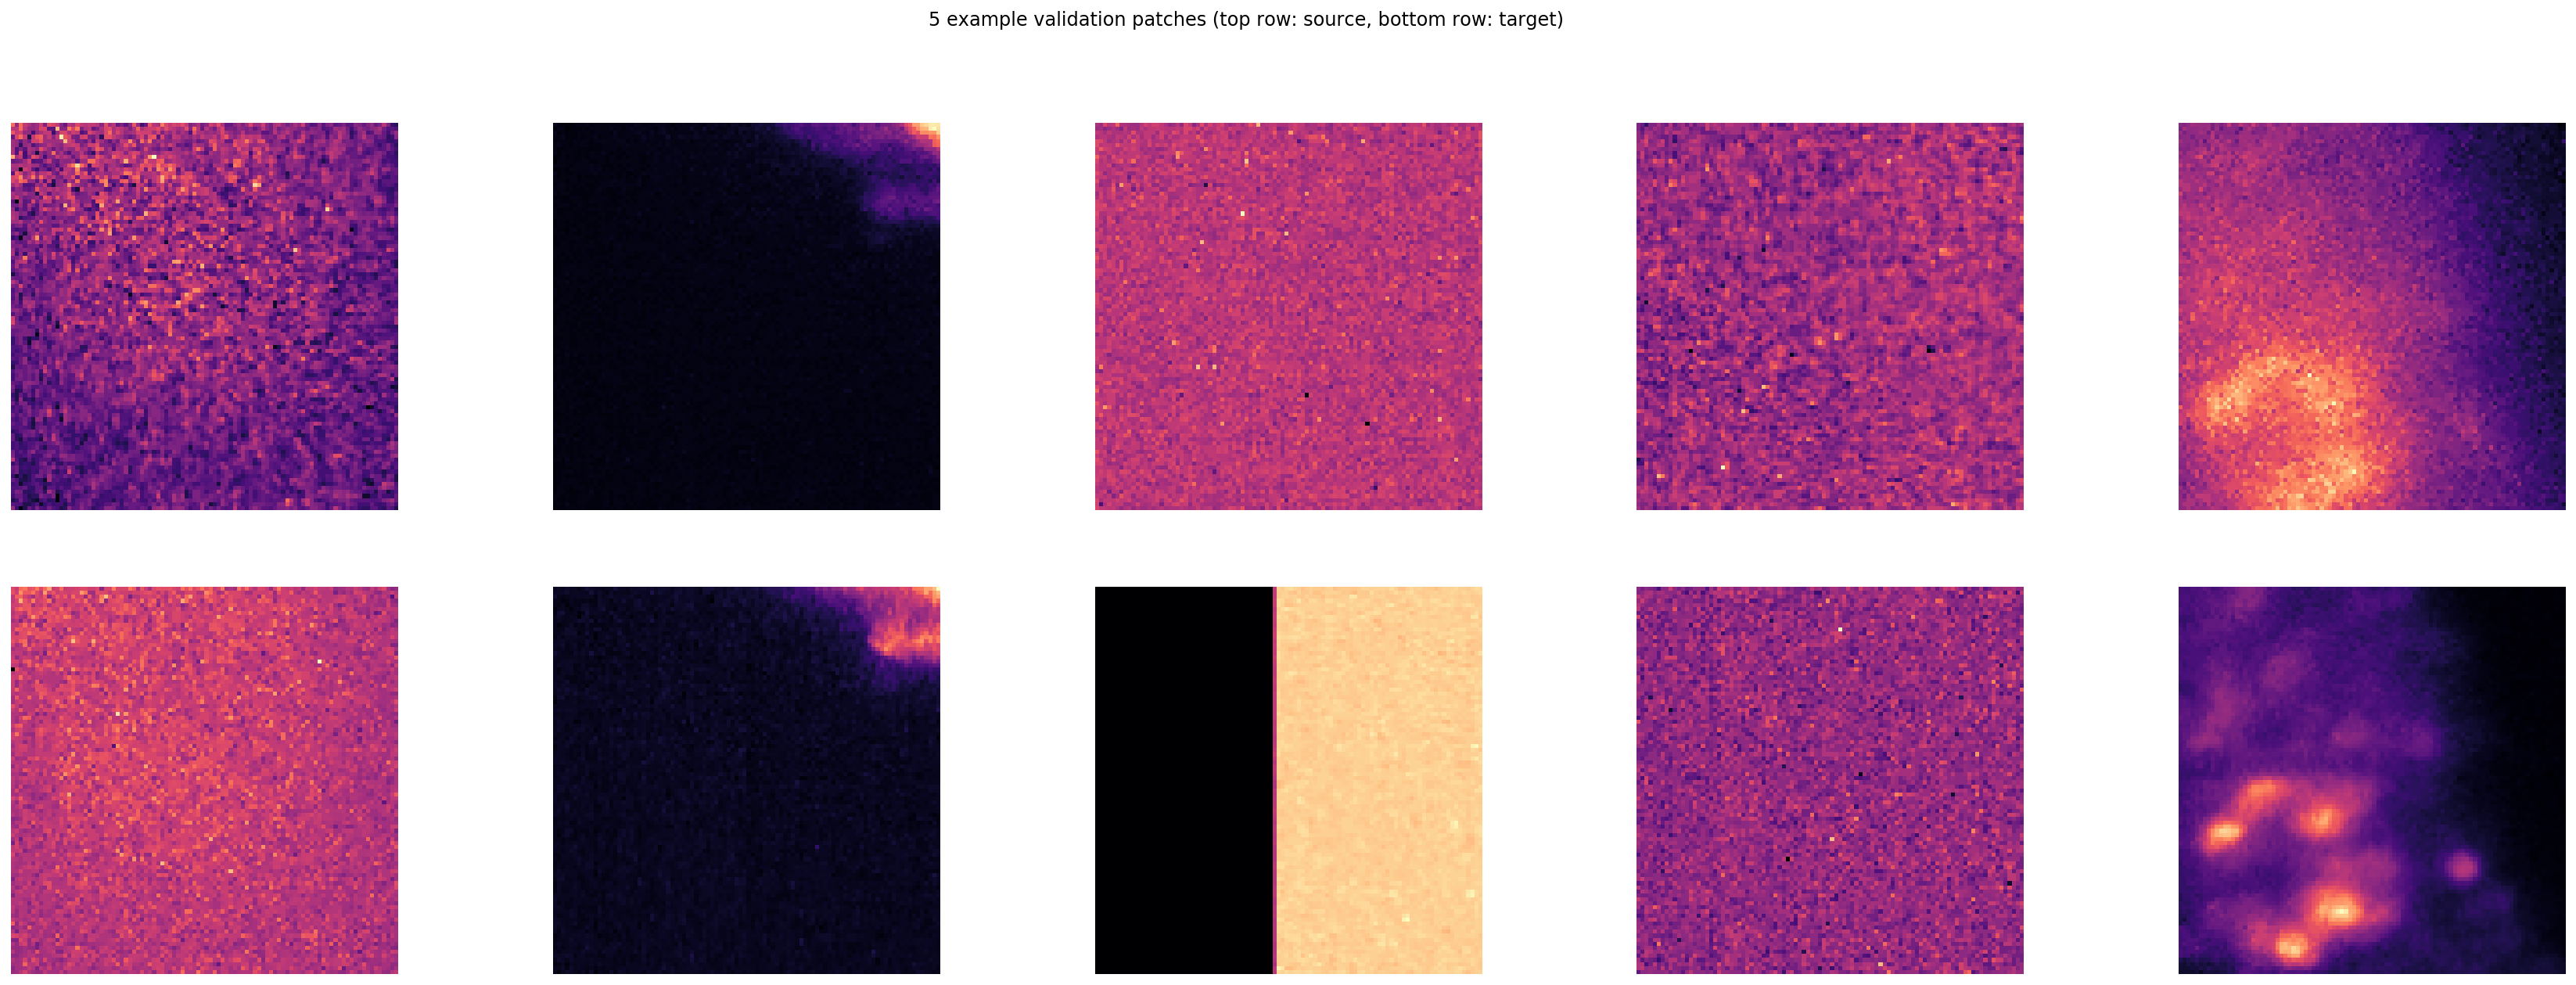

In [15]:
plt.figure(figsize=(30,10))
plot_some(X_val[150:155, ...],Y_val[150:155, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [16]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=500, train_epochs=500, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=500, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=500, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 500,
 'train_steps_per_epoch': 500,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [17]:
model = CARE(config, 'care_2D_kellerlab', basedir='models')

In [18]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/02_SoftwareExecutables/anaconda3/envs/N2V368/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 3.2% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/500
500/500 [==============================] - 45s 90ms/step - loss: 19.7100 - mse: 17106.7318 - mae: 19.7100 - val_loss: 11.9820 - val_mse: 935.7176 - val_mae: 11.9820
Epoch 2/500
500/500 [==============================] - 43s 87ms/step - loss: 11.8362 - mse: 872.5519 - mae: 11.8362 - val_loss: 11.9635 - val_mse: 926.5829 - val_mae: 11.9635
Epoch 3/500
500/500 [==============================] - 43s 87ms/step - loss: 12.1047 - mse: 926.9010 - mae: 12.1047 - val_loss: 13.9915 - val_mse: 1009.6036 - val_mae: 13.9915
Epoch 4/500
500/500 [==============================] - 43s 86ms/step - loss: 11.5290 - mse: 860.1041 - mae: 11.5290 - val_loss: 12.0256 - val_mse: 960.5003 - val_mae: 12.0256
Epoch 5/500
500/500 [==============================] - 43s 86ms/step - loss: 11.9065 - mse: 904.0765 - mae: 11.9065 - val_loss: 11.6056 - val_mse: 945.8291 - val_mae: 11.6056
Epoch 6/500
500/500 [==============================] - 43s 86ms/step - loss: 11.2026 - mse: 835.1934 - mae: 11.2026 - val_

500/500 [==============================] - 43s 86ms/step - loss: 10.8978 - mse: 831.2063 - mae: 10.8978 - val_loss: 11.1975 - val_mse: 918.4777 - val_mae: 11.1975
Epoch 48/500
500/500 [==============================] - 43s 85ms/step - loss: 11.2674 - mse: 870.2851 - mae: 11.2674 - val_loss: 11.7041 - val_mse: 912.1996 - val_mae: 11.7041
Epoch 49/500
500/500 [==============================] - 43s 85ms/step - loss: 11.1652 - mse: 833.3782 - mae: 11.1652 - val_loss: 11.1713 - val_mse: 919.8519 - val_mae: 11.1713
Epoch 50/500
500/500 [==============================] - 43s 86ms/step - loss: 11.4542 - mse: 901.9506 - mae: 11.4542 - val_loss: 11.3498 - val_mse: 914.6720 - val_mae: 11.3498
Epoch 51/500
500/500 [==============================] - 43s 87ms/step - loss: 11.2577 - mse: 890.7311 - mae: 11.2577 - val_loss: 11.2007 - val_mse: 921.3045 - val_mae: 11.2007
Epoch 52/500
500/500 [==============================] - 43s 85ms/step - loss: 11.0962 - mse: 836.7350 - mae: 11.0962 - val_loss: 11.4

500/500 [==============================] - 43s 86ms/step - loss: 10.0797 - mse: 726.0451 - mae: 10.0797 - val_loss: 10.1211 - val_mse: 788.7600 - val_mae: 10.1211
Epoch 94/500
500/500 [==============================] - 43s 86ms/step - loss: 10.2275 - mse: 762.9709 - mae: 10.2275 - val_loss: 9.9548 - val_mse: 761.3742 - val_mae: 9.9548
Epoch 95/500
500/500 [==============================] - 43s 86ms/step - loss: 10.1421 - mse: 751.6309 - mae: 10.1421 - val_loss: 10.1279 - val_mse: 740.4247 - val_mae: 10.1279
Epoch 96/500
500/500 [==============================] - 43s 85ms/step - loss: 10.1365 - mse: 746.7920 - mae: 10.1365 - val_loss: 9.8220 - val_mse: 741.4182 - val_mae: 9.8220
Epoch 97/500
500/500 [==============================] - 43s 86ms/step - loss: 10.3074 - mse: 752.7432 - mae: 10.3074 - val_loss: 9.8791 - val_mse: 737.3735 - val_mae: 9.8791
Epoch 98/500
500/500 [==============================] - 43s 85ms/step - loss: 9.9895 - mse: 723.5198 - mae: 9.9895 - val_loss: 9.8013 - val

500/500 [==============================] - 43s 85ms/step - loss: 9.5583 - mse: 677.2513 - mae: 9.5583 - val_loss: 9.2166 - val_mse: 655.9573 - val_mae: 9.2166
Epoch 141/500
500/500 [==============================] - 43s 85ms/step - loss: 9.5129 - mse: 659.9359 - mae: 9.5129 - val_loss: 9.3081 - val_mse: 656.1833 - val_mae: 9.3081
Epoch 142/500
500/500 [==============================] - 43s 87ms/step - loss: 9.4083 - mse: 661.8682 - mae: 9.4083 - val_loss: 9.2341 - val_mse: 650.1576 - val_mae: 9.2341
Epoch 143/500
500/500 [==============================] - 42s 85ms/step - loss: 9.6099 - mse: 683.2015 - mae: 9.6099 - val_loss: 9.3555 - val_mse: 650.4825 - val_mae: 9.3555
Epoch 144/500
500/500 [==============================] - 43s 85ms/step - loss: 9.5493 - mse: 680.1345 - mae: 9.5493 - val_loss: 9.2729 - val_mse: 639.5920 - val_mae: 9.2729
Epoch 145/500
500/500 [==============================] - 43s 85ms/step - loss: 9.7004 - mse: 688.8329 - mae: 9.7004 - val_loss: 9.3287 - val_mse: 642

Epoch 187/500
500/500 [==============================] - 43s 86ms/step - loss: 9.3684 - mse: 652.9674 - mae: 9.3684 - val_loss: 8.9588 - val_mse: 620.8288 - val_mae: 8.9588
Epoch 188/500
500/500 [==============================] - 43s 85ms/step - loss: 9.3858 - mse: 657.0846 - mae: 9.3858 - val_loss: 8.8466 - val_mse: 598.8222 - val_mae: 8.8466
Epoch 189/500
500/500 [==============================] - 43s 86ms/step - loss: 9.1018 - mse: 617.5092 - mae: 9.1018 - val_loss: 8.7753 - val_mse: 581.8891 - val_mae: 8.7753
Epoch 190/500
500/500 [==============================] - 43s 85ms/step - loss: 9.1385 - mse: 642.4047 - mae: 9.1385 - val_loss: 8.8864 - val_mse: 596.1613 - val_mae: 8.8864
Epoch 191/500
500/500 [==============================] - 43s 86ms/step - loss: 9.2354 - mse: 640.7495 - mae: 9.2354 - val_loss: 8.9134 - val_mse: 598.2452 - val_mae: 8.9134
Epoch 192/500
500/500 [==============================] - 43s 86ms/step - loss: 9.1800 - mse: 634.5540 - mae: 9.1800 - val_loss: 8.8924 

Epoch 234/500
500/500 [==============================] - 43s 85ms/step - loss: 8.6594 - mse: 556.2704 - mae: 8.6594 - val_loss: 8.2408 - val_mse: 500.8806 - val_mae: 8.2408
Epoch 235/500
500/500 [==============================] - 43s 87ms/step - loss: 8.5500 - mse: 556.9169 - mae: 8.5500 - val_loss: 8.1865 - val_mse: 498.2248 - val_mae: 8.1865
Epoch 236/500
500/500 [==============================] - 43s 86ms/step - loss: 8.2644 - mse: 518.5993 - mae: 8.2644 - val_loss: 8.3030 - val_mse: 508.6182 - val_mae: 8.3030
Epoch 237/500
500/500 [==============================] - 43s 87ms/step - loss: 8.4051 - mse: 537.6701 - mae: 8.4051 - val_loss: 8.1957 - val_mse: 505.5550 - val_mae: 8.1957
Epoch 238/500
500/500 [==============================] - 43s 85ms/step - loss: 8.4473 - mse: 543.4566 - mae: 8.4473 - val_loss: 8.1564 - val_mse: 496.2564 - val_mae: 8.1564
Epoch 239/500
500/500 [==============================] - 43s 86ms/step - loss: 8.2433 - mse: 508.7631 - mae: 8.2433 - val_loss: 8.1638 

Epoch 281/500
500/500 [==============================] - 43s 86ms/step - loss: 8.0807 - mse: 501.9948 - mae: 8.0807 - val_loss: 7.9369 - val_mse: 471.4623 - val_mae: 7.9369
Epoch 282/500
500/500 [==============================] - 43s 85ms/step - loss: 8.1564 - mse: 523.5806 - mae: 8.1564 - val_loss: 7.9206 - val_mse: 472.2828 - val_mae: 7.9206
Epoch 283/500
500/500 [==============================] - 43s 86ms/step - loss: 8.2256 - mse: 518.4480 - mae: 8.2256 - val_loss: 7.9193 - val_mse: 470.9832 - val_mae: 7.9193
Epoch 284/500
500/500 [==============================] - 43s 85ms/step - loss: 8.0203 - mse: 508.9815 - mae: 8.0203 - val_loss: 7.9591 - val_mse: 476.8307 - val_mae: 7.9591
Epoch 285/500
500/500 [==============================] - 43s 86ms/step - loss: 8.1571 - mse: 517.8817 - mae: 8.1571 - val_loss: 8.1137 - val_mse: 485.7504 - val_mae: 8.1137
Epoch 286/500
500/500 [==============================] - 43s 85ms/step - loss: 8.0034 - mse: 486.7644 - mae: 8.0034 - val_loss: 8.1765 

Epoch 328/500
500/500 [==============================] - 43s 86ms/step - loss: 8.0510 - mse: 493.3654 - mae: 8.0510 - val_loss: 7.8026 - val_mse: 462.7323 - val_mae: 7.8026
Epoch 329/500
500/500 [==============================] - 43s 86ms/step - loss: 7.6125 - mse: 462.1231 - mae: 7.6125 - val_loss: 7.7975 - val_mse: 466.1759 - val_mae: 7.7975
Epoch 330/500
500/500 [==============================] - 43s 86ms/step - loss: 8.1555 - mse: 508.8177 - mae: 8.1555 - val_loss: 7.9164 - val_mse: 469.0084 - val_mae: 7.9164
Epoch 331/500
500/500 [==============================] - 43s 85ms/step - loss: 7.8147 - mse: 480.9022 - mae: 7.8147 - val_loss: 7.9169 - val_mse: 471.6207 - val_mae: 7.9169
Epoch 332/500
500/500 [==============================] - 43s 85ms/step - loss: 8.1222 - mse: 516.7824 - mae: 8.1222 - val_loss: 7.7846 - val_mse: 462.9582 - val_mae: 7.7846
Epoch 333/500
500/500 [==============================] - 43s 85ms/step - loss: 8.0313 - mse: 493.1916 - mae: 8.0313 - val_loss: 7.8887 

500/500 [==============================] - 43s 86ms/step - loss: 7.7878 - mse: 482.4558 - mae: 7.7878 - val_loss: 7.7639 - val_mse: 463.1628 - val_mae: 7.7639
Epoch 376/500
500/500 [==============================] - 43s 86ms/step - loss: 8.0461 - mse: 503.0920 - mae: 8.0461 - val_loss: 7.8202 - val_mse: 462.1002 - val_mae: 7.8202
Epoch 377/500
500/500 [==============================] - 43s 86ms/step - loss: 7.7279 - mse: 477.0046 - mae: 7.7279 - val_loss: 8.0351 - val_mse: 478.6287 - val_mae: 8.0351
Epoch 378/500
500/500 [==============================] - 43s 86ms/step - loss: 7.9349 - mse: 487.7654 - mae: 7.9349 - val_loss: 7.7705 - val_mse: 465.9062 - val_mae: 7.7705
Epoch 379/500
500/500 [==============================] - 43s 85ms/step - loss: 7.8827 - mse: 496.3554 - mae: 7.8827 - val_loss: 7.7714 - val_mse: 460.2689 - val_mae: 7.7714
Epoch 380/500
500/500 [==============================] - 43s 86ms/step - loss: 7.8344 - mse: 475.3858 - mae: 7.8344 - val_loss: 7.7387 - val_mse: 457

Epoch 422/500
500/500 [==============================] - 43s 85ms/step - loss: 7.7856 - mse: 486.4444 - mae: 7.7856 - val_loss: 7.7195 - val_mse: 459.4629 - val_mae: 7.7195
Epoch 423/500
500/500 [==============================] - 43s 85ms/step - loss: 7.5741 - mse: 450.2987 - mae: 7.5741 - val_loss: 7.7708 - val_mse: 460.0308 - val_mae: 7.7708
Epoch 424/500
500/500 [==============================] - 43s 85ms/step - loss: 7.8236 - mse: 479.0907 - mae: 7.8236 - val_loss: 7.7066 - val_mse: 457.5274 - val_mae: 7.7066
Epoch 425/500
500/500 [==============================] - 43s 86ms/step - loss: 7.8211 - mse: 469.2729 - mae: 7.8211 - val_loss: 7.7247 - val_mse: 457.0660 - val_mae: 7.7247
Epoch 426/500
500/500 [==============================] - 43s 85ms/step - loss: 7.8199 - mse: 497.1797 - mae: 7.8199 - val_loss: 7.6966 - val_mse: 457.4144 - val_mae: 7.6966
Epoch 427/500
500/500 [==============================] - 43s 85ms/step - loss: 7.8167 - mse: 487.2026 - mae: 7.8167 - val_loss: 7.7136 

500/500 [==============================] - 43s 85ms/step - loss: 7.7396 - mse: 474.2987 - mae: 7.7396 - val_loss: 7.6800 - val_mse: 452.2073 - val_mae: 7.6800
Epoch 469/500
500/500 [==============================] - 43s 85ms/step - loss: 7.4909 - mse: 441.5705 - mae: 7.4909 - val_loss: 7.6946 - val_mse: 453.6950 - val_mae: 7.6946
Epoch 470/500
500/500 [==============================] - 43s 86ms/step - loss: 8.0105 - mse: 509.6757 - mae: 8.0105 - val_loss: 7.6777 - val_mse: 452.3667 - val_mae: 7.6777

Epoch 00470: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 471/500
500/500 [==============================] - 43s 85ms/step - loss: 7.5971 - mse: 472.3595 - mae: 7.5971 - val_loss: 7.6715 - val_mse: 451.9006 - val_mae: 7.6715
Epoch 472/500
500/500 [==============================] - 43s 85ms/step - loss: 7.7720 - mse: 475.6342 - mae: 7.7720 - val_loss: 7.6856 - val_mse: 452.8036 - val_mae: 7.6856
Epoch 473/500
500/500 [==============================] - 43s 85ms/st

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


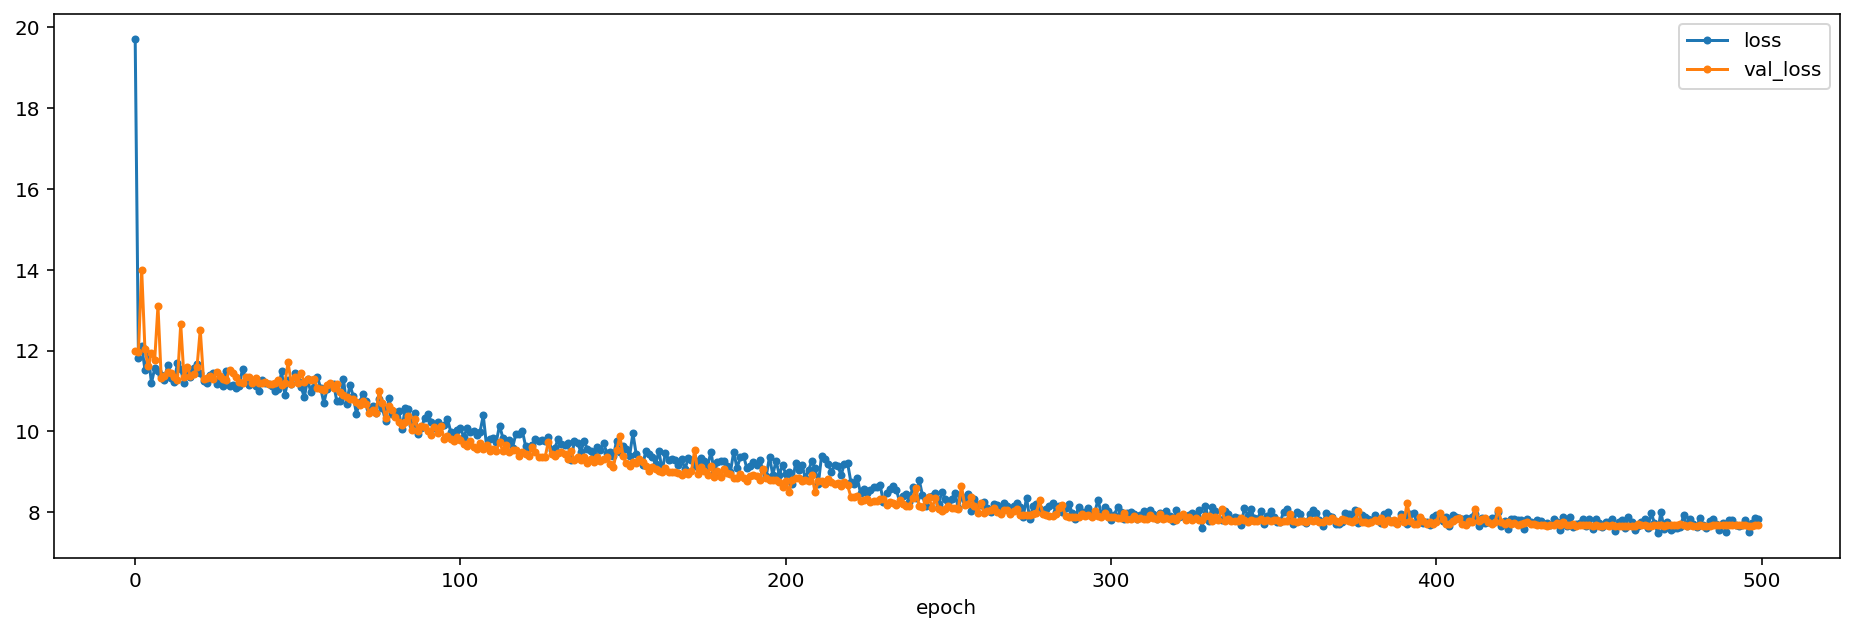

In [20]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);